# Optical Flow

Optical flow tracks objects by looking at where the *same* points have moved from one image frame to the next. Let's load in a few example frames of a pacman-like face moving to the right and down and see how optical flow finds **motion vectors** that describe the motion of the face!

As usual, let's first import our resources and read in the images.

In [2]:
import numpy as np
import matplotlib.image as mpimg  # for reading in images
import matplotlib.pyplot as plt
import cv2  # computer vision library
%matplotlib inline

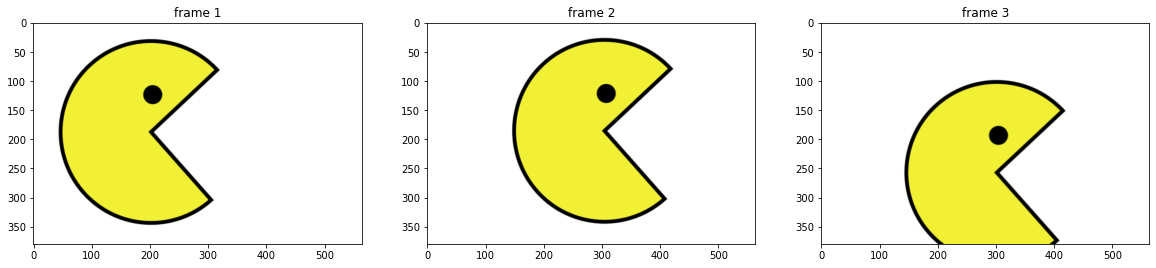

In [3]:

# Read in the image frames
frame_1 = cv2.imread('images/pacman_1.png')
frame_2 = cv2.imread('images/pacman_2.png')
frame_3 = cv2.imread('images/pacman_3.png')

# convert to RGB
frame_1 = cv2.cvtColor(frame_1, cv2.COLOR_BGR2RGB)
frame_2 = cv2.cvtColor(frame_2, cv2.COLOR_BGR2RGB)
frame_3 = cv2.cvtColor(frame_3, cv2.COLOR_BGR2RGB)


# Visualize the individual color channels
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('frame 1')
ax1.imshow(frame_1)
ax2.set_title('frame 2')
ax2.imshow(frame_2)
ax3.set_title('frame 3')
ax3.imshow(frame_3)


## Finding Points to Track

Before optical flow can work, we have to give it a set of *keypoints* to track between two image frames!

In the below example, we use a **Shi-Tomasi corner detector**, which uses the same process as a Harris corner detector to find patterns of intensity that make up a "corner" in an image, only it adds an additional parameter that helps select the most prominent corners. You can read more about this detection algorithm in [the documentation](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_shi_tomasi/py_shi_tomasi.html). 

Alternatively, you could choose to use Harris or even ORB to find feature points. I just found that this works well.

**You sould see that the detected points appear at the corners of the face.**

[[[318.  82.]]

 [[308. 304.]]

 [[208. 188.]]

 [[309.  81.]]

 [[299. 304.]]

 [[199. 188.]]]


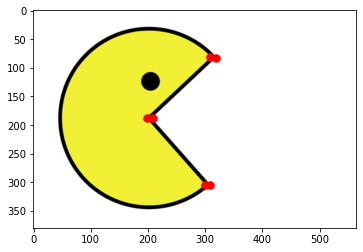

In [4]:
# We need to pass keypoints to trrack to the Optical Flow API
# We use the Shi-Tomasi corner dteector, similar to the Harris corner detector
# We can use Harris or ORB instead, too
# Parameters for ShiTomasi corner detection
feature_params = dict( maxCorners = 10,
                       qualityLevel = 0.2,
                       minDistance = 5,
                       blockSize = 5 )

# Convert all frames to grayscale
gray_1 = cv2.cvtColor(frame_1, cv2.COLOR_RGB2GRAY)
gray_2 = cv2.cvtColor(frame_2, cv2.COLOR_RGB2GRAY)
gray_3 = cv2.cvtColor(frame_3, cv2.COLOR_RGB2GRAY)

# Take first frame and find corner points in it
pts_1 = cv2.goodFeaturesToTrack(gray_1, mask = None, **feature_params)

# Display the detected points
plt.imshow(frame_1)
for p in pts_1:
    # plot x and y detected points
    plt.plot(p[0][0], p[0][1], 'r.', markersize=15)

# Print out the x-y locations of the detected points
print(pts_1)

## Perform Optical Flow

Once we've detected keypoints on our initial image of interest, we can calculate the optical flow between this image frame (frame 1) and the next frame (frame 2), using OpenCV's `calcOpticalFlowPyrLK` which is [documented, here](https://docs.opencv.org/trunk/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323). It takes in an initial image frame, the next image, and the first set of points, and it returns the detected points in the next frame and a value that indicates how good matches are between points from one frame to the next.

The parameters also include a window size and maxLevels that indicate the size of a window and number of levels that will be used to scale the given images using pyramid scaling; this version peforms an iterative search for matching points and this matching criteria is reflected in the last parameter (you may need to change these values if you are working with a different image, but these should work for the provided example).

In [25]:
# Parameters for Lucas-Kanade optical flow
# winSize: size of the search window at each pyramid level
# maxLevel: 0, pyramids are not used (single level), if set to 1, two levels are used, and so on
# criteria: termination criteria of the iterative search algorithm
lk_params = dict( winSize  = (5,5), 
                  maxLevel = 2, 
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Calculate optical flow between first and second frame
# The function implements a sparse iterative version
# of the Lucas-Kanade optical flow in pyramids.
# We pass: first image, next image, first points, parameters
# We get:
# - next points
# - status/match: 1 if the flow for the corresponding features has been found, otherwise, it is set to 0.
# - error values
pts_2_of, match, err = cv2.calcOpticalFlowPyrLK(gray_1, gray_2, pts_1, None, **lk_params)

# Select good matching points between the two image frames
good_new = pts_2_of[match==1]
good_old = pts_1[match==1]

In [26]:
err

array([[134.92],
       [126.04],
       [100.92],
       [101.52],
       [113.4 ],
       [130.16]], dtype=float32)

Next, let's display the resulting motion vectors! You should see the first image with motion vectors drawn on it that indicate the direction of motion from the first frame to the next.

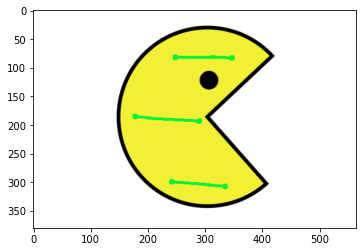

In [27]:
# Create a mask image for drawing (u,v) vectors on top of the second frame
mask = np.zeros_like(frame_2)

# Draw the lines between the matching points (these lines indicate motion vectors)
for i,(new,old) in enumerate(zip(good_new,good_old)):
    a,b = new.ravel()
    c,d = old.ravel()
    # draw points on the mask image
    mask = cv2.circle(img=mask, center=(a,b), radius=5, color=(200), thickness=-1)
    # draw motion vector as lines on the mask image
    mask = cv2.line(img=mask, pt1=(a,b), pt2=(c,d), color=(200), thickness=3)
    # add the line image and second frame together

# Overlay mask
composite_im = np.copy(frame_2)
composite_im[mask!=0] = [0]

# It doesn't seem to work that well; maybe the movement was too big
plt.imshow(composite_im)

### TODO: Perform Optical Flow between image frames 2 and 3

Repeat this process but for the last two image frames; see what the resulting motion vectors look like. Imagine doing this for a series of image frames and plotting the entire-motion-path of a given object.


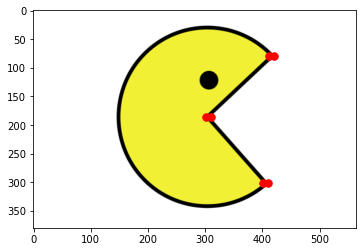

In [31]:
# We perform optical flow between image frames 2 and 3

# Get Shi-Tomasi points
pts_2_st = cv2.goodFeaturesToTrack(gray_2, mask = None, **feature_params)
plt.imshow(frame_2)
for p in pts_2:
    plt.plot(p[0][0], p[0][1], 'r.', markersize=15)

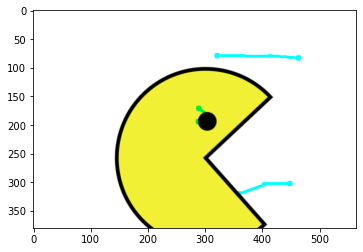

In [32]:
# Optical Flow
# We can try the Shi-Tomasi points or the previous optical flow points
pts_3_of, match, err = cv2.calcOpticalFlowPyrLK(gray_2, gray_3, pts_2_st, None, **lk_params)

# Select good matching points between the two image frames
good_new = pts_3_of[match==1]
good_old = pts_2_st[match==1]

# Create a mask image for drawing (u,v) vectors on top of the second frame
# Draw the lines between the matching points (these lines indicate motion vectors)
mask = np.zeros_like(frame_3)
for i,(new,old) in enumerate(zip(good_new,good_old)):
    a,b = new.ravel()
    c,d = old.ravel()
    mask = cv2.circle(img=mask, center=(a,b), radius=5, color=(200), thickness=-1)
    mask = cv2.line(img=mask, pt1=(a,b), pt2=(c,d), color=(200), thickness=3)

# Overlay mask and plot
composite_im = np.copy(frame_3)
composite_im[mask!=0] = [0]
plt.imshow(composite_im)